In [2]:
# Core Libraries
import os
import json
import pandas as pd
import numpy as np
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Audio/Video utilities
import librosa
import librosa.display
import cv2

# For notebook display
from IPython.display import display, Audio, HTML

# Configure plots
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# Project Paths
DATA_DIR = Path("../data/datasets")


In [3]:
# List all datasets
datasets = [d for d in DATA_DIR.iterdir() if d.is_dir()]
for d in datasets:
    print(f"📂 {d.name}")
    for sub in d.iterdir():
        print(f"   ├── {sub.name}")


📂 fake-and-real-news-dataset
   ├── Fake.csv
   ├── True.csv
📂 fakeddit_subset
   ├── fakeddit_subset
📂 FakeNewsNet-torchtext-dataset-json
   ├── .git
   ├── fakenewsnet_sm.json
   ├── LICENSE
   ├── README.md
   ├── util_dataset.py
   ├── util_negative.py
   ├── util_sentence.py
📂 ffpp_subset
   ├── manipulated_sequences
   ├── original_sequences
📂 snopes_medical
   ├── outputs
📂 WaveFake
   ├── fake
   ├── real


,title,text,label
22216,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",FAKE
4436,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,REAL
1526,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,REAL
1377,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",FAKE
8995,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",REAL


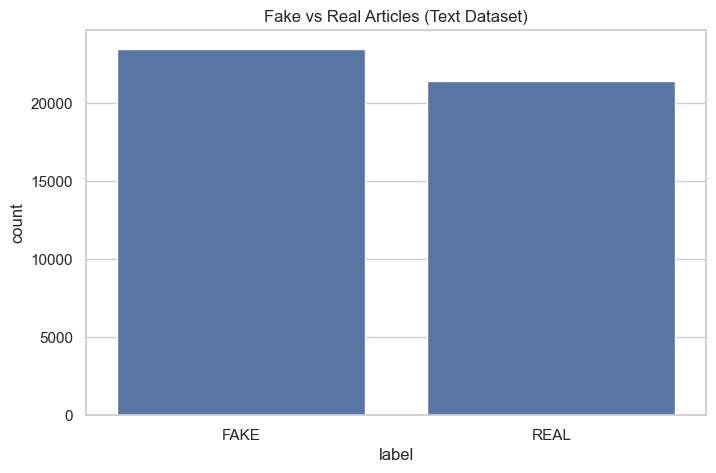

In [4]:
fake_df = pd.read_csv(DATA_DIR / "fake-and-real-news-dataset/Fake.csv")
true_df = pd.read_csv(DATA_DIR / "fake-and-real-news-dataset/True.csv")

fake_df["label"] = "FAKE"
true_df["label"] = "REAL"
text_df = pd.concat([fake_df, true_df]).sample(5, random_state=42)

display(text_df[["title", "text", "label"]].head())

# Label distribution
sns.countplot(x="label", data=pd.concat([fake_df, true_df]))
plt.title("Fake vs Real Articles (Text Dataset)")
plt.show()


In [14]:
fakeddit_path = Path("../data/datasets/fakeddit_subset/fakeddit_subset")
train_file = fakeddit_path / "training_data_fakeddit.jsonl"

records = []
with open(train_file, "r", encoding="utf-8") as f:
    for line in f:
        item = json.loads(line.strip())
        try:
            user_parts = item["contents"][0]["parts"]
            model_parts = item["contents"][1]["parts"]

            image_uri = user_parts[0]["fileData"]["fileUri"]
            text = user_parts[1]["text"]
            label = model_parts[0]["text"].strip()

            records.append({
                "Text": text,
                "Image": image_uri,
                "Label": label
            })
        except Exception as e:
            continue  # skip malformed lines

df_fakeddit = pd.DataFrame(records)
print(f"Loaded {len(df_fakeddit)} entries.")
display(df_fakeddit.head(5))


Loaded 4000 entries.


,Text,Image,Label
0,"Title:""he cut some tomatoes and put them in a ...",gs://my_trial_bucket_finetune/image_folder/9a4...,Yes
1,"Title:""crazy tennis face ripe for the photosho...",gs://my_trial_bucket_finetune/image_folder/18b...,No
2,"Title:""spicy vitamin water exists""\n\nis the p...",gs://my_trial_bucket_finetune/image_folder/44a...,No
3,"Title:""football helmet tester""\n\nis the pictu...",gs://my_trial_bucket_finetune/image_folder/083...,No
4,"Title:""shoryuken""\n\nis the picture and title ...",gs://my_trial_bucket_finetune/image_folder/06c...,Yes


In [18]:
print("Label distribution:")
print(df_fakeddit["Label"].value_counts())

print("\nMissing values per column:")
print(df_fakeddit.isnull().sum())


Label distribution:
Label
No     2291
Yes    1709
Name: count, dtype: int64

Missing values per column:
Text         0
Image        0
Label        0
ImagePath    0
dtype: int64


In [29]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to your local image folder
local_base = r"..\data\datasets\fakeddit_subset\fakeddit_subset"

def get_local_image_path(gcs_uri):
    """Convert a GCS URI to a local image path if it exists."""
    if gcs_uri.startswith("gs://my_trial_bucket_finetune/"):
        local_path = gcs_uri.replace("gs://my_trial_bucket_finetune", local_base)
        return local_path if os.path.exists(local_path) else None
    return None

# Example test
sample_uri = "gs://my_trial_bucket_finetune/image_folder/9a46c1362ec06f0ffbd2578fa777ea8d.jpg"
print(get_local_image_path(sample_uri))


..\data\datasets\fakeddit_subset\fakeddit_subset/image_folder/9a46c1362ec06f0ffbd2578fa777ea8d.jpg


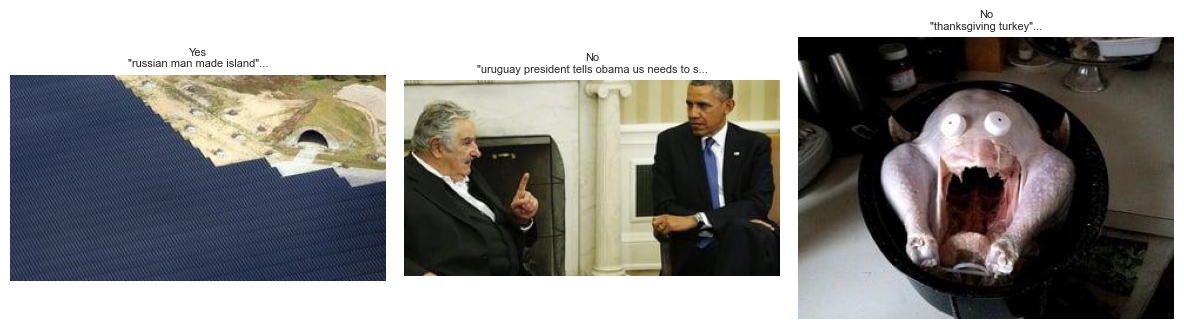

In [31]:
import json
import random

# Path to your training data
json_path = r"..\data\datasets\fakeddit_subset\fakeddit_subset\training_data_fakeddit.jsonl"

with open(json_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

# Pick 3 random examples
sample_lines = random.sample(lines, 3)

plt.figure(figsize=(12, 6))
for i, line in enumerate(sample_lines):
    entry = json.loads(line)
    user_part = entry["contents"][0]["parts"][1]["text"]
    img_uri = entry["contents"][0]["parts"][0]["fileData"]["fileUri"]
    label = entry["contents"][1]["parts"][0]["text"]

    local_path = get_local_image_path(img_uri)

    plt.subplot(1, 3, i + 1)
    if local_path and os.path.exists(local_path):
        img = mpimg.imread(local_path)
        plt.imshow(img)
        plt.title(f"{label}\n{user_part.splitlines()[0][6:50]}...", fontsize=8)
    else:
        plt.text(0.5, 0.5, "No Image Found", ha="center", va="center")
        plt.title("Missing Image")
    plt.axis('off')

plt.tight_layout()
plt.show()
